# NB. Interpolation and Integration

> Saleh Rezaeiravesh and Philipp Schlatter <br />
  salehr@kth.se, pschlatt@mech.kth.se <br />
  SimEx/FLOW, KTH Engineering Mechanics, Royal Institute of Technology, Stockholm, Sweden

> This notebook is a part of the [KTH-Nek5000 lecture notes](https://kth-nek5000.github.io/kthNekBook/).

In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import math as mt
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (14,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
pi=mt.pi

## Nodes
Consider variable $x \in X$. There are different options for nodes $\{x_i\}_{i=1}^n$ to be taken from $X$. 
Nodes play a central role in numerical, interpolation, integration and collocation methods. 
In a discrete setting, the function $f(x)$, *e.g.* a solution variable of a differential equation, is represented and evaluated at the nodal set. 
The most trivial option for the nodal set is to adopt uniformly-spaced nodes.
However, this option can lead to the **Runge phenomenon**, where large over/undershoots occur near the boundary nodes. 
You will see examples of this in the notebooks in this course. 
To avoid this phenomenon and hence increase the order of accuracy, nodes which are compressed towards the boundaries of $X$ can be chosen. To this end, different options are available including the zeros or extrema of polynomials. 

Here we provide two types of nodes which will be used throughout this notebook. 

**Chebyshev polynomials** are defined as, 

$$
\begin{equation}
T_k(x) = \cos(k \arccos x) \ , \ \ k=0, 1, 2, \ldots \ .
\end{equation}
$$

* The extrema of $T_{n}(x)$ specify **Gauss-Lobatto-Chebyshev (GLC)** or Chebyshev points of the second kind:

$$
\begin{equation}
x_k=\cos\left(\frac{\pi (k-1)}{n-1}\right)\,,\quad k=1,2,\cdots,n
\end{equation}\label{glc}\tag{GLC}
$$

**Legendre polynomials** can be defined through the following recursive expressions:

$$
\begin{equation}   
   L_0(x) = 1\,,\quad L_1(x)=x\,,\quad (k+1) L_{k+1}(x) = (2k+1) x L_k(x) - k L_{k-1}(x)\,,\quad k\geq 1   
\end{equation}\label{gll}\tag{GLL}
$$

Of our particular interest in this course are the **Gauss-Lobatto-Legendre (GLL)** nodes defined as,

$$
\begin{equation}
(1-x)^2 L'_{n-1}(x) = 0\,,\quad 
\end{equation}
$$
where, $x_1=-1$, $x_{n}=1$, and $x_k$ are zeros of $L'_{n-1}(x)$ for $k=2,3,\cdots,n-1$.


**Note:** All the above-mentioned nodes are in $[-1,1]$. 

For a given $n$, the `Python` functions below return the value of the above nodes and associated quadrature weights (see "Numerical Integration" section).

In [2]:
def GLC_pwts(n):
    """ 
    Gauss-Lobatto-Chebyshev (GLC) points and weights over [-1,1]        
    Reference:
       https://archive.siam.org/books/ot103/OT103%20Dahlquist%20Chapter%205.pdf
    Args: 
      `n`: int, number of points
    Returns 
       `x`: 1D numpy array of size `n`, points
       `w`: 1D numpy array of size `n`, weights
    """
    def c(i,n):
        c_=2.
        if i==0 or i==n-1:
           c_=1.
        return c_
    theta=np.arange(n)*pi/(n-1)
    x=np.cos(theta)
    w=np.zeros(n)
    for k in range(n):
        tmp_=0.0
        for j in range(1,int((n-1)/2)+1):
            bj=2
            if n%2!=0 and j==int((n-1)/2):
               bj=1
            tmp_+=bj/(4.*j**2-1)*mt.cos(2*j*theta[k])
        w[k]=(1-tmp_)*c(k,n)/float(n-1)
    return x,w

def GLL_pwts(n,eps=10**-8,maxIter=1000):
    """
    Generating `n `Gauss-Lobatto-Legendre (GLL) nodes and weights using the 
    Newton-Raphson iteration.
    Args:    
      `n`: int
         Number of GLL nodes
      `eps`: float (optional) 
         Min error to keep the iteration running
      `maxIter`: float (optional)
         Max number of iterations
    Outputs:
      `xi`: 1D numpy array of size `n`
         GLL nodes
      `w`: 1D numpy array of size `n`
         GLL weights
    Reference:
       Canuto C., Hussaini M. Y., Quarteroni A., Tang T. A., 
       "Spectral Methods in Fluid Dynamics," Section 2.3. Springer-Verlag 1987.
       https://link.springer.com/book/10.1007/978-3-642-84108-8
    """
    V=np.zeros((n,n))  #Legendre Vandermonde Matrix
    #Initial guess for the nodes: GLC points
    xi,w_=GLC_pwts(n)
    iter_=0
    err=1000
    xi_old=xi
    while iter_<maxIter and err>eps:
        iter_+=1
        #Update the Legendre-Vandermonde matrix
        V[:,0]=1.
        V[:,1]=xi
        for j in range(2,n):
            V[:,j]=((2.*j-1)*xi*V[:,j-1] - (j-1)*V[:,j-2])/float(j)
        #Newton-Raphson iteration 
        xi=xi_old-(xi*V[:,n-1]-V[:,n-2])/(n*V[:,n-1])
        err=max(abs(xi-xi_old).flatten())
        xi_old=xi
    if (iter_>maxIter and err>eps):
       print('gllPts(): max iterations reached without convergence!')
    #Weights
    w=2./(n*(n-1)*V[:,n-1]**2.)
    return xi,w

Let's call these functions and plot different nodes:

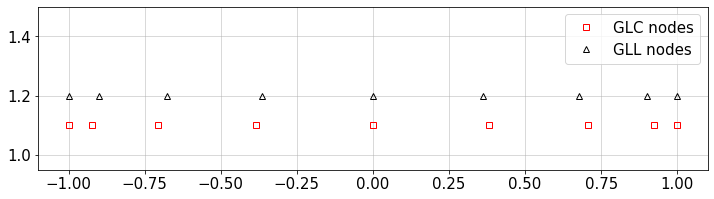

In [3]:
n=9  #number of nodes
xGLC,w_=GLC_pwts(n)
xGLL,w_=GLL_pwts(n)
#plot
plt.figure(figsize=(12,3))
plt.plot(xGLC,0.1+np.ones(n),'sr',mfc='none',label='GLC nodes')
plt.plot(xGLL,0.2+np.ones(n),'^k',mfc='none',label='GLL nodes')
plt.legend(loc='best')
plt.ylim([0.95,1.5])
plt.grid()
plt.show()

## Interpolation

### Interpolation with Given Bases
Consider a set of discrete values $\{f_i\}_{i=1}^n$ where $f_i=f(x_i)$.

For a set of basis functions $\mathbf{\Phi}(x)$, an interpolant $\tilde{f}(x)$ can be constructed based on the nodal values:

$$
\tilde{f}(x) = \sum_{k=0}^K \hat{f}_k \Phi_k(x)
$$

Examples of the $\Phi_k(x)$ are Fourier bases, Chebyshev polynomials, Legendre polynomials, etc, see the other notebooks in this chapter.

To compute unknown coefficients $\{\hat{f}_k\}_{k=0}^K$, there are two main methods:

1. **Collocation method**: 

Given the nodal values $\{f_i\}_{i=1}^n$, the bases $\Phi_k(x)$ are evaluated at $\{x_i\}_{i=1}^n$ and as a result a linear system of equations is formed to compute $\{\hat{f}_k\}_{k=0}^K$. 

2. **Projection method**: 

This approach is based on numerical integration. Therefore, it is advantageous for the polynomial bases which are *orthogonal*. The coefficients are computed as,

$$
\hat{f}_k = \frac{\int f(x) \Phi_k(x) {\rm d}x}{\int \Phi_k(x) \Phi_k(x) {\rm d}x} = 
\frac{\langle f(x), \Phi_k(x)\rangle}{\langle\Phi_k(x) , \Phi_k(x)\rangle} \,,
$$

where $\langle \cdot,\cdot \rangle$ specifies weighted inner-product in the space spanned by the bases.

Details of these two methods are provided in the notebooks on Fourier transform and Chebyshev polynomials. 

### Lagrange Interpolation
Consider $\{f(x_i)\}_{i=1}^n$ at $n$ distinct nodes $\{x_i\}_{i=1}^n$ taken from $X$. 
Given these, the aim is to construct a polynomial interpolant of maximum degree of $(n-1)$ for $f(x)$ over $X$.

A straightforward approach to construct the interpolant $\tilde{f}(x)$ is to use **Lagrange polynomial bases**:

$$
\begin{equation}
\tilde{f}(x) = \sum_{i=1}^n f_i l_i(x) \,
\end{equation} \label{lag1} \tag{1}
$$

where, 

$$
\begin{equation}
l_i(x) = \prod_{{{j=1},{j\neq i}}}^{n} \frac{x-x_j}{x_i-x_j} \,
\end{equation}\label{lag2} \tag{2}
$$ 

where $l_i(x_j)=\delta_{ij}$. 
The extension of the interpolation formula to multidimensional input is straightforward. 

In [4]:
#Standard Lagrange interpolation
def lagInterp(x,f,xTest):
    """
    Lagrange interpolation in 1D space
    """
    n=len(x)
    m=len(xTest)
    k=np.arange(n)
    Lk=np.zeros((n,m))
    for k_ in k:
        prod_=1.0
        for j in range(n):
            if j!=k_:
               prod_*=(xTest-x[j])/(x[k_]-x[j])
        Lk[k_,:]=prod_  
    fInterp=np.matmul(f[None,:],Lk).T    
    return Lk,fInterp[:,0]

For the following smooth and non-smooth functions $f(x)$, change the number of nodes and see how close the interpolated curve becomes to the analytical one. 
How to measure the error? 

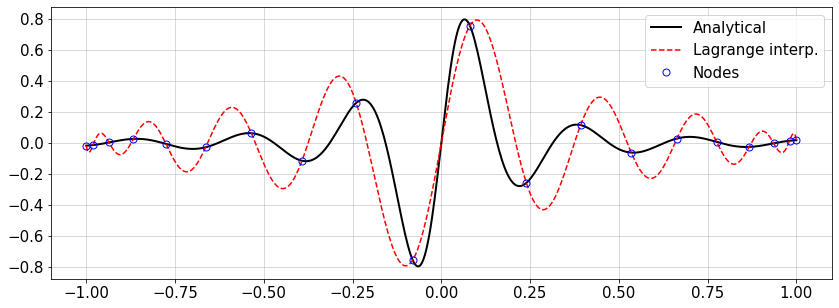

In [5]:
# Example for Lagrange interpolation
#f = lambda x: abs(np.sin(20*(x+0.5))/(x+0.5))*(np.sin(10*(x-0.2))/(x-0.2))   #non-smooth
f = lambda x: (np.sin(20*(x-1*np.mean(x)))/(1+50.*(x-np.mean(x))**2.))    #smooth function

#---- Settings----
n=20   #number of interpolation nodes
#-----------------
#x,w=GLC_pwts(n)     #GLC nodes
x,w=GLL_pwts(n)      #GLL nodes

xTest=np.linspace(-1.,1.,500)
Lk,fInt=lagInterp(x,f(x),xTest)

#plot
plt.figure(figsize=(14,5))
plt.plot(xTest,f(xTest),'-k',lw=2,label='Analytical')
plt.plot(xTest,fInt,'--r',label='Lagrange interp.')
plt.plot(x,f(x),'ob',ms=7,mfc='none',label='Nodes')
plt.legend(loc='best')
plt.grid()

The Lagrange polynomials can also be plotted:

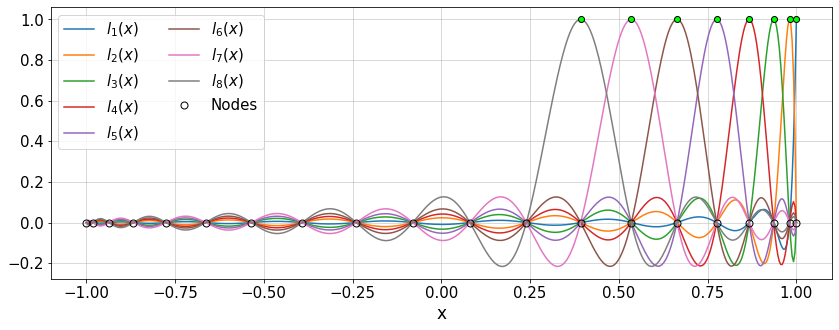

In [6]:
plt.figure(figsize=(14,5))
for i in range(8):
    plt.plot(xTest,Lk[i,:],'-',label=r'$l_{'+str(i+1)+'}(x)$')
    plt.plot(x[i],[1.0],'ok',mfc='lime')
plt.plot(x,np.zeros(x.size),'ok',ms=7,label='Nodes')    
plt.legend(ncol=2)
plt.grid()
plt.xlabel('x')
#plt.xlim([0.8,1])
plt.show()

#### Exercise
Repeat the above example using uniformly-spaced nodes. What behavior do you observe? What is the phenomenon called?

### Barycentric Interpolation

**Basic idea:** consider a system of $n$ particles with mass $w_0, w_1, \cdots, w_n$ located at $x_0,x_1,\cdots,x_n$. The **center of gravity** or **barycenter** of the particle system is unique and defined as, 

$$
x=\frac{\sum_{i=1}^n w_i x_i}{\sum_{i=1}^n w_i} \,.
$$

Analogous to this, a **barycentric interpolation** is defined as, see *e.g.* [Hormann](https://www.inf.usi.ch/hormann/papers/Hormann.2014.BI.pdf), 

$$
\begin{equation}
\tilde{f}(x)=\sum_{i=1}^n b_i(x) f_i \,,
\end{equation}\label{bary1}\tag{3}
$$

where the **barycentric bases** satisfy the following properties:
1. $\sum_{i=1}^n  b_i(x) =1 \,,$
2. $\sum_{i=1}^n b_i(x) x_i =x \,,$
3. $b_i(x_j)=\delta_{ij} \,.$


#### Exercise: 
Show whether or not these properties hold for Lagrange interpolation ([1](#mjx-eqn-lag1)).

### Barycentric Lagrange Interpolation

According to [Berrut and Trefethen](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf), the standard formulation of the Lagrange interpolation, see equations ([1](#mjx-eqn-lag1)) and ([2](#mjx-eqn-lag2)), suffers from a few shortcomings:

  1. Each evaluation of $\tilde{f}(x)$ needs $\mathcal{O}(n^2)$ multiplications and additions. 
  2. If we add a new point $(x_{n+1},f(x_{n+1}))$, then all the computations should be repeated.
  3. The computations can be numerically unstable. 

Given these, [Berrut and Trefethen](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) derived a barycentric version of Lagrange interpolation. 

Let us start from the numerator in ([2](#mjx-eqn-lag2)) which can be rewritten as,

$$
\begin{equation}
 \prod_{{{j=1},{j\neq i}}}^{n}(x-x_j) =
 \frac{(x-x_1)(x-x_2)\cdots(x-x_n)}{(x-x_i)}
:= \frac{\ell(x)}{(x-x_i)}
\end{equation}\label{lagbar1}\tag{4}
$$
Moreover, the barycentric weights are defined based on the denominator of ([2](#mjx-eqn-lag2)):

$$
\begin{equation}
 w_i:=1/{\prod_{{{j=1},{j\neq i}}}^{n} (x_i-x_j)} \,.
\end{equation}\label{lagbar2}\tag{5}
$$
The $\ell(x)$ defined in ([4](#mjx-eqn-lagbar1)) applies to all terms in ([1](#mjx-eqn-lag1)). Therefore, ([1](#mjx-eqn-lag1)) is rewritten as, 

$$
\begin{equation}
\tilde{f}(x) = \ell(x) \sum_{i=1}^n \frac{w_i}{(x-x_i)}f_i \,.
\end{equation}\label{lagbar3}\tag{6}
$$
Now consider a case with $f_i=1$ for $i=1,2,\cdots,n$. As a result we get, 

$$
\begin{equation}
1 = \ell(x) \sum_{i=1}^n \frac{w_i}{(x-x_i)}\cdot 1 \,.
\end{equation}\label{lagbar4}\tag{7}
$$
Dividing  ([6](#mjx-eqn-lagbar3)) by ([7](#mjx-eqn-lagbar4)) leads to the **barycentric formulation of Lagrange interpolation**:

$$
\begin{equation}
\tilde{f}(x) = \frac{\sum_{i=1}^n \frac{w_i}{(x-x_i)} f_i}{\sum_{i=1}^n \frac{w_i}{(x-x_i)}}
\end{equation}\label{lagbar5}\tag{8}
=\sum_{i=1}^n b_i(x) f_i \,.
$$

According to [Berrut and Trefethen](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf), the formulation ([8](#mjx-eqn-lagbar5)) has nice properties:
1. The weights in the numerator and denominator are the same. As a result of this symmetry, any common factor in them will be canceled out. 
2. If a new data $(x_{n+1},f(x_{n+1}))$ is to be added to a current interpolant, the update will cost $\mathcal{O}(n)$ operations. 

#### Exercise 
Show that the properties of the barycentric interpolation are satisfied for ([8](#mjx-eqn-lagbar5)).

Here is a `Python` implementation of the barycentric Lagrange interpolation:

In [7]:
# Barycentric Lagrange Interpolation
def baryLagrange(x,f,xTest):
    """
    Barycentric Lagrange Interpolation
    """
    n=len(x)
    nTest=len(xTest)    
    num_=np.zeros(nTest)
    den_=np.zeros(nTest)
    for i in range(n):        
        w_=1.0
        for j in range(n):
            if i!=j:
               w_*=x[i]-x[j]                       
        tmp_=1/((xTest-x[i])*w_)
        num_+=f[i]*tmp_
        den_+=tmp_
    fInterp=num_/den_  
    return fInterp

We test the above implementation using GLC nodes. 
We can either choose one of the implemented functions for $f(x)$ or implement an arbitrary expression. 

error =  0.06637255067748846


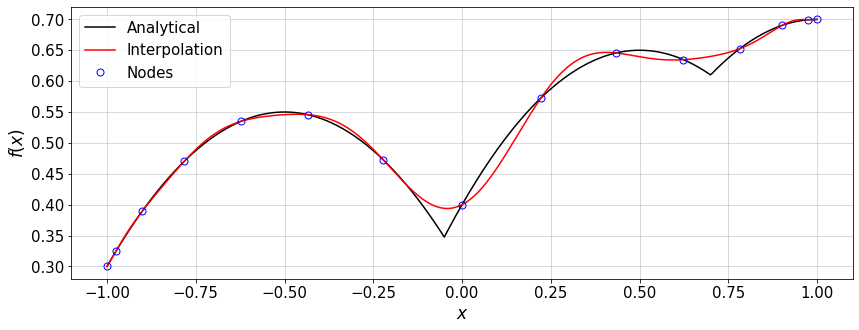

In [8]:
#Example inspired by Berrut and Trefethen, 2004
f = lambda x: abs(x+.05)+0.5*x-x**2.+0.5*abs(x-0.7)   #non-smooth
#f = lambda x: (np.sin(20*(x-1*np.mean(x)))/(1+50.*(x-np.mean(x))**2.))    #smooth function

#---- Settings----
n=15   #number of interpolation nodes
#-----------------
x,w=GLC_pwts(n)
fx=f(x)
eps_=1e-10
xTest=np.linspace(-1.+eps_,1.-eps_,500)
fInterp=baryLagrange(x,fx,xTest)
#plot
plt.figure(figsize=(14,5))
plt.plot(xTest,f(xTest),'-k',label='Analytical')
plt.plot(xTest,fInterp,'-r',label='Interpolation')
plt.plot(x,fx,'ob',ms=7,mfc='none',label='Nodes')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.grid()
plt.legend(loc='best')
err=norm((fInterp-f(xTest)),np.inf)/norm(f(xTest),np.inf)
print('error = ',err)

Now we can compare the convergence rate of the Lagrange interpolation for a smooth and a $C^0$ function on GLC nodes.

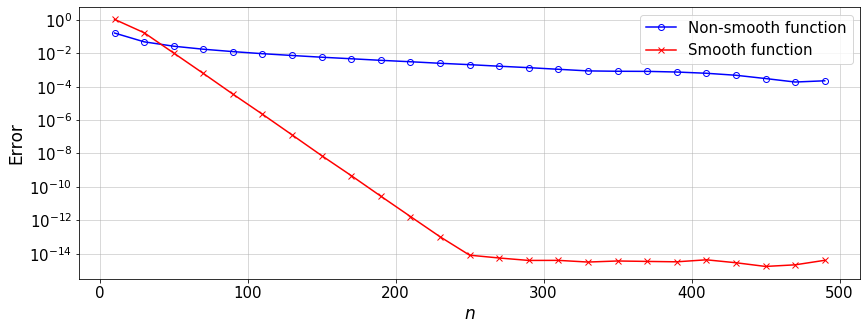

In [9]:
f = lambda x: abs(x)+0.5*x-x**2.+0.5*abs(x-0.7)  #non-smooth function
g = lambda x: (np.sin(20*(x-1*np.mean(x)))/(1+50.*(x-np.mean(x))**2.))    #smooth function

N=[]
Err_f=[]
Err_g=[]
eps_=1e-8
xTest=np.linspace(-1.+eps_,1.-eps_,300)
for n in range(10,500,20):
    N.append(n)
    xCheb,w=GLC_pwts(n)    
    fInterp=baryLagrange(xCheb,f(xCheb),xTest)
    Err_f.append(norm((fInterp-f(xTest)),np.inf)/norm(f(xTest),np.inf))
    fInterp=baryLagrange(xCheb,g(xCheb),xTest)
    Err_g.append(norm((fInterp-g(xTest)),np.inf)/norm(g(xTest),np.inf))   
    
#plot
plt.figure(figsize=(14,5))
plt.semilogy(N,Err_f,'-ob',label='Non-smooth function')
plt.plot(N,Err_g,'-xr',label='Smooth function')
plt.xlabel(r'$n$')
plt.ylabel(r'Error')
plt.legend(loc='best')
plt.grid()

**Discussion:** What is your conclusion about the convergence rate of different functions? What would change if we use Chebyshev, GLL, or even equidistant nodes?

### Explicit Formulas for barycentric Lagrange weights
For special types of nodes, explicit formulas can be derived for weights $w_i$ appearing in ([8](#mjx-eqn-lagbar5)). 
The followings are taken from  [Berrut and Trefethen](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf).

**1. Equidistant nodes:**
Over the interval $[a,b]$, we have 

$$
w_i= 2^n (b-a)^{-n}(-1)^i \binom{n}{i}  = 2^n (b-a)^{-n}(-1)^i \frac{n! }{i!\,(n-i)!} \,,
$$

where $2^n (b-a)^{-n}$ will be canceled out in ([8](#mjx-eqn-lagbar5)). 
1. For large $n$, the weights exponentially grow approximately as $2^n$. Therefore, the small values at the center of the interval can grow and oscillate by order of $2^n$ near the boundary nodes (**Runge phenomenon**).
2. The interpolation using equidistant nodes is **ill-conditioned**, meaning that small perturbations in the values $f_i$ can lead to large variations in the interpolant. 

**2. GLC (Gauss-Lobatto-Chebyshev) points:** 
There are four different types of Chebyshev nodes, corresponding to each, an exact formula can be derived for weights $w_i$. In particular for the Chebyshev points of second kind (or GLC nodes) which are defined in ([GLC](#mjx-eqn-glc)), the corresponding weights are given by,

$$
w_i = (-1)^i \delta_i,\quad\quad 
\text{where}\,,
\delta_i=
\begin{cases}
1/2 &,\, \text{boundary nodes}\\
1 &,\, \text{otherwise}
\end{cases} \,.
$$

#### Exercise
Consider the GLC nodes ([GLC](#mjx-eqn-glc)) with an odd $n$. Implement the barycentric Lagrange interpolation with the above weights. Then, for the same set of nodal values compare the interpolation result with what is obtained from the general Barycentric Lagrange interpolation implemented in `baryLagrange()`. 

## Numerical Integration
### Quadrature Rules
Consider the definite integral,

$$
I=\int_{-1}^1 f(x) \rho(x) {\rm d}x  \,,
$$

where, $f(x)$ is an integrand and $\rho(x)$ is a weight function. 
The integral can be numerically approximated by a **quadrature rule** which is written as a **weighted sum**: 

$$
I_n = \sum_{i=1}^n W_i f(x_i) \,,
$$

where, $x_i$ and $W_i$ denote the i-th quadrature point and weight in the rule, respectively.
Note than in the case of integration over interval $[a,b]$, a linear transform is needed to map $[a,b]$ to $[-1,1]$. 


There are different quadrature rules, including those where the quadrature points are taken to be the zeros of the orthogonal polynomial bases used for expanding a function. 
For instance, in Gauss-Legendre and Gauss-Chebyshev rules, the quadrature points are the zeros of the Legendre and Chebyshev polynomials, respectively. 
In Lobatto rule, the end points on interval $[-1,1]$ are also added to the quadrature points. 
Of particular interest for us, is the Gauss-Lobatto-Legendre rule. 


- For a review on numerical integration see [here](https://archive.siam.org/books/ot103/OT103%20Dahlquist%20Chapter%205.pdf) and Chapter 2 in [Canuto *et al.*](https://link.springer.com/book/10.1007/978-3-642-84108-8). 
- For integration using Chebyshev polynomials, see *e.g.* [here](http://inis.jinr.ru/sl/m_mathematics/mref_references/mason,%20hanscomb.%20chebyshev%20polynomials%20(2003)/c0355-ch08.pdf). 


Here we consider two different rules, for both $\rho(x)=1$:


* **Clenshaw-Curtis rule:**
The quadrature points are the GLC points or Chebyshev points of the second kind given by ([GLC](#mjx-eqn-glc)). The associated weights are (see *e.g.* [section 5.1.6, here](https://archive.siam.org/books/ot103/OT103%20Dahlquist%20Chapter%205.pdf)):

$$
\begin{equation}
W_i=\frac{4\delta_i}{n}\sum_{k=0}^{[n/2]} \frac{\delta_{2k}}{1-4k^2} \cos\left( \frac{2ik\pi}{n}\right) \,,
\end{equation}
$$
where, 

$$
\delta_i=
\begin{cases}
1/2 &,\, \text{boundary nodes}\\
1 &,\, \text{otherwise}
\end{cases} \,.
$$

* **Gauss-Lobatto-Legendre rule:**
The quadrature points are defined in ([GLL](#mjx-eqn-gll)), and the associated weights are (see *e.g.* Chapter 2 in [Canuto *et al.*](https://link.springer.com/book/10.1007/978-3-642-84108-8):

$$
\begin{equation}
W_i = \frac{2}{n(n-1)} \frac{1}{(L_{n-1}(x_i))^2} \,,\quad i=1,2,\cdots,n \,,
\end{equation}
$$
where, $L_k(x)$ is the Legendre polynomial of order $k$. 

The quadrature points and weights for these approaches are implemented in `GLC_pwts()` and `GLL_pwts()`, respectively. 

We want to compare the convergence of the above two quadrature rules for integration of polynomials. 
The `Python` function `polyInteg()` generates a polynomial of maximum order $N$, *i.e.* $f(x)\in\mathbb{P}_{N}$ with random coefficients. 
Then $\int_{-1}^1 f(x) {\rm d}x$ is computed exactly, and also approximated by Clenshaw-Curtis and Gauss-Lobatto-Legendre rules. 

In [10]:
# Quadrature rule for GLL nodes applied to polynomials
def polyInteg(N,Q):
    """
    Compute exact and CC and GLL quadrature integrals of a polynomial of order `N` 
    Coefficients of the polynomial are randomly chosen from a uniform distribution. 
    args:
       `N`: polynomial order
       `Q`: number of quadrature nodes and weights
    """  
    p=np.random.rand(N+1)*(5.+2.)-2.  #polynomial coefficients \in [-2,5]
    if p[0]<1e-6:
       p[0]==1 
    #exact integration of the polynomial
    pInteg=[]
    for i in range(N+1):
        pInteg.append(p[i]/float(N+1-i))
    pInteg.append(0.0)    #increase order of monomials by 1
    #evaluate the polynomial and its exact integral
    x=np.linspace(-1,1,500)
    fx=np.polyval(p,x)
    fInteg_exact=np.polyval(pInteg,1.0)-np.polyval(pInteg,-1.0)
    #Approximate the integral by quadrature rules
    #Clenshaw-Curtis quadrature rule 
    xi,w=GLC_pwts(Q)    
    fInteg_cc=np.sum(w*np.polyval(p,xi))            
    #GLL quadrature rule 
    xi,w=GLL_pwts(Q)
    fInteg_GLL=np.sum(w*np.polyval(p,xi))
    return x,fx,fInteg_exact,fInteg_cc,fInteg_GLL

Now, for an arbitrary polynomial order $N$, we can study the convergence of the numerical integral to the exact value when increasing `Q`, the number of quadrature points (Note that $Q=n$):

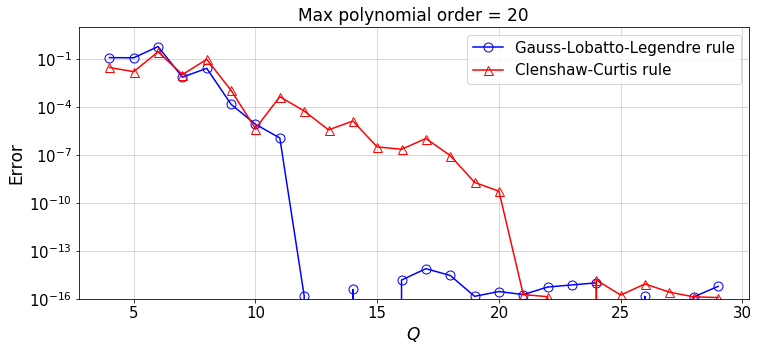

In [11]:
#----- Settings
N=20   #polynomial order
#---------------
Q=[]
Error_gll=[]
Error_cheby=[]
Error_cc=[]
for Q_ in range(4,30,1):
    x,fx,fInteg_exact,fInteg_cc,fInteg_GLL=polyInteg(N,Q_)
    err_=abs(fInteg_GLL-fInteg_exact)/abs(fInteg_exact)    
    Error_gll.append(err_)
    err_=abs(fInteg_cc-fInteg_exact)/abs(fInteg_exact)    
    Error_cc.append(err_)                
    Q.append(Q_)  
       
#plot
plt.figure(figsize=(12,5))
plt.semilogy(Q,Error_gll,'-ob',ms=9,label='Gauss-Lobatto-Legendre rule')    
plt.plot(Q,Error_cc,'-^r',ms=9,label='Clenshaw-Curtis rule')    
plt.xlabel(r'$Q$')
plt.ylabel('Error')
plt.title('Max polynomial order = %d' %N)
plt.legend(loc='best')
plt.ylim([1e-16,10])
plt.grid()

**Discussion:**
* Repeat the above test for different polynomial orders, `N`.
* Given the polynomial order `N`, at what value of `Q` is a large error reduction observed for each of the quadrature rules? What is your conclusion?

**Observations and Conclusions** 

1. We observe the fact that, the **GLL quadrature rule based on $Q$ quadrature points can exactly integrate a polynomial of up to order $2Q-3$.**

2. For a polynomial function $f(x)$, we observe that the convergence of the integral $\int_{-1}^1 f(x){\rm d}x$ by the GLL rule can be twice faster than that of the Clenshaw-Curtis rule. 

3. The observation 2. does NOT necessarily hold for a general $f(x)$. See the interesting article by [L. Trefethen](https://courses.engr.illinois.edu/cs591mh/fa2012/trefethen/Clenshaw-Curtis.pdf).  

### Over-integration

Consider $f(x)\in \mathbb{P}_{N}$, where $\mathbb{P}_{N}$ is a polynomial of order $N$. This polynomial can have at most $n=N+1$ non-zero coefficients or modes. 

Adopting the GLL quadrature rule, we can estimate the number of quadrature points $Q$ required to exactly integrate different powers of $f(x)$:

  * $f(x)\in \mathbb{P}_N$ requires $Q=(n+2)/2$
  * $f^2(x)\in \mathbb{P}_{2N}$ requires $Q=n+1/2$  
  * $f^3(x)\in \mathbb{P}_{3N}$ requires $Q=3n/2$

As you will see further in the course, in spectral element method (SEM), $f(x)$ can be expanded as $f(x)=\sum_{i=0}^{N} a_i \varphi_i(x)$. 
In the Galerkin formulation of the Navier-Stokes equations, for the non-linear convective term in the momentum equation we need to evaluate an integral over an element with the integrand which is $\in  \mathbb{P}_{3N}$.
Therefore, we need to use $Q=3n/2$, where $n$ represents the *number of GLL points* per element (in each spatial direction), to ensure the convective term is exactly integrated. 
This is called **over-integration** which corresponds to the **dealiasing** in Fourier spectral methods. 
For further discussion and examples about over-integration, see [Kirby and Karniadakis](https://www.sciencedirect.com/science/article/pii/S0021999103003140). 

> **Reading Recommendation:**
* [**Six Myths of Polynomial Interpolation and Quadrature**](https://people.maths.ox.ac.uk/trefethen/mythspaper.pdf) by L. Trefethern.